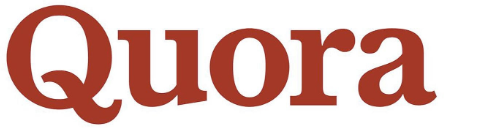

<h1 style="font-size:60px;" align=center>Duplicate Question Detection</h1>

In [1]:
from IPython.display import HTML
HTML('''
<form action="javascript:IPython.notebook.execute_cells_below()"><input type="submit" value="Launch"></form>''')

In [2]:
from IPython.display import HTML,Image, IFrame
headers = {
    'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36",
    'content-type': "application/json",
    'accept': "application/json"
}

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="code"></form>''')

In [3]:
import pandas as pd, numpy as np
import requests, re, json, os, time, urllib, warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Layout, interact, interact_manual, fixed
import xgboost as xgb
warnings.simplefilter(action='ignore')

In [4]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
stops = set(stopwords.words("english"))

bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bst')

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R


with open('weights.json','r') as f:
    weights = json.load(f)

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [5]:
def predict(_):
    q1 = qs1.value
    q2 = qs2.value
    clear_output()
    display(box)
    df = pd.DataFrame({'question1':[q1],'question2':[q2]})
    tfidf_train_word_match = df.apply(tfidf_word_match_share, axis=1)
    train_word_match = df.apply(word_match_share, axis=1)
    res = bst.predict(xgb.DMatrix(pd.DataFrame([train_word_match,tfidf_train_word_match]).T))
    res = 0 if res <= 0.5 else 1
    render_res(res)

def render_res(res):
    if res==0:
        display(Image('not_duplicate.png'))
    else:
        display(Image('duplicate.png'))

In [6]:
qs1 = widgets.Text(
    value='',
    placeholder='Question 1',
    description='',
    disabled=False,
    layout=Layout(width ='850px')
)
qs2 = widgets.Text(
    value='',
    placeholder='Question 2',
    description='',
    disabled=False,
    layout=Layout(width ='850px')
)
submit = widgets.Button(
    description='Check Duplication',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='search' # (FontAwesome names without the `fa-` prefix)
)


box = widgets.VBox(
    [
        qs1,
        qs2,
        submit
    ]
)

display(box)
submit.on_click(predict)